In [633]:
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import inspect
import datetime
from scipy.stats import percentileofscore
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import add_preds
from functions import merge_data
from viz import  viz_interactive
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import matplotlib as plt
from scipy.stats import percentileofscore

# CHANGE THIS
from exponential_modeling import *
from fit_and_predict import *
from pmdl_weights import * 

In [649]:
# Load in the Data
print('loading data...')
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))
#df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST,
#                          cached_dir=oj(parentdir, 'data'))

loading data...
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,#Deaths_05-24-2020,#Deaths_05-25-2020,#Deaths_05-26-2020,#Deaths_05-27-2020,deaths,cases,tot_deaths,tot_cases,neighbor_deaths,neighbor_cases
1843,36047,36.0,47.0,Kings,NY,New York,40.640578,-73.954654,40.650523,-73.954811,...,6504,6517,6533,6544,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6544,54779,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1860,36081,36.0,81.0,Queens,NY,New York,40.683532,-73.814712,40.721294,-73.833451,...,6097,6112,6121,6128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6128,61125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1822,36005,36.0,5.0,Bronx,NY,New York,40.856182,-73.864945,40.849354,-73.882363,...,4226,4240,4245,4255,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4255,44503,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
602,17031,17.0,31.0,Cook,IL,Illinois,41.842959,-87.821180,41.865937,-87.757714,...,3304,3324,3354,3455,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...",3455,74521,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1850,36061,36.0,61.0,New York,NY,New York,40.770216,-73.974271,40.777958,-73.966303,...,2723,2729,2732,2740,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2740,26213,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [635]:
# Currently selecting confirmed cases, can look at probable later
df_ucsf = pd.read_csv("../../covid-19-private-data/ucsf_hospitalization_data.csv", sep="\t")
df_ucsf = df_ucsf[["Date", "ZSFG COVID-19+ (total admitted)"]]
df_ucsf = df_ucsf.rename(columns={"ZSFG COVID-19+ (total admitted)": "hospitalizations"})
df_ucsf_hosp = df_ucsf["hospitalizations"] 
UCSF_data = np.array(df_ucsf_hosp.to_numpy())
UCSF_data
#UCSF_data = UCSF_data.reshape(1,UCSF_data.shape[0])
#df_shared_UCSF.head()
#print(UCSF_data[40])


array([ 0,  0,  1,  1,  0,  0,  0,  0,  1,  3,  2,  1,  0,  1,  2,  2,  4,
        7,  7,  7,  9, 13, 15, 16, 18, 21, 23, 22, 25, 27, 30, 30, 30, 32,
       31, 33, 34, 28, 25, 25, 27, 25, 24, 26, 25, 26, 25, 23, 18, 19, 19,
       22, 24, 25])

In [581]:
#Linear,Exponential,Shared_Exponential Eval Mode for UCSF Data
start_day = 20;
lin_predictions = []
exp_predictions = []
shared_exp_predictions = []
for i in range(start_day,UCSF_data.shape[0]):   
    tmp = UCSF_data[:i+1]
    d = {'Name':['UCSF'],'hospitalizations':[tmp]}
    df_shared_UCSF = pd.DataFrame(data = d)
    shared_pred = fit_and_predict_shared_exponential(df_shared_UCSF,mode = "eval_mode",outcome = "hospitalizations")
    shared_exp_predictions.append(shared_pred[0][0])
    tmp = tmp.reshape(1,tmp.shape[0])
    lin_pred = linear_fit(tmp,'eval_mode')
    lin_predictions.append(lin_pred[0][0])
    exp_pred = exponential_fit(tmp,'eval_mode')
    exp_predictions.append(exp_pred[0][0])
   

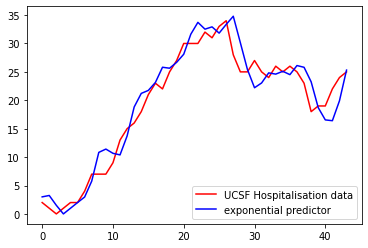

In [590]:
plt.plot(UCSF_data[start_day:],'r',label='UCSF Hospitalisation data')
plt.plot(exp_predictions,'b',label='exponential predictor')
plt.legend()

#ax3.plot(UCSF_data[start_day:],'r',label='UCSF Hospitalisation data')
#ax3.plot(shared_exp_predictions,'b',label="Shared Predictor")

#ax1.legend()
#ax2.legend()
#ax3.legend()

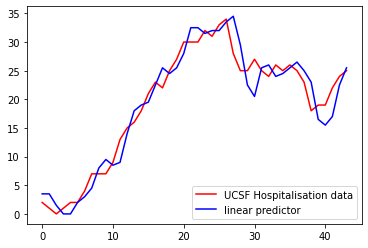

In [591]:
plt.plot(UCSF_data[start_day:],'r',label='UCSF Hospitalisation data')
plt.plot(lin_predictions,'b',label='linear predictor')
plt.legend()


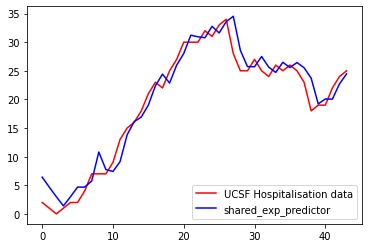

In [593]:
plt.plot(UCSF_data[start_day:],'r',label='UCSF Hospitalisation data')
plt.plot(shared_exp_predictions,'b',label='shared_exp_predictor')
plt.legend()

In [641]:
start_day = 20;
lin_future_predictions = []
exp_future_predictions = []
shared_exp_future_predictions = []
k = 3
for i in range(start_day,UCSF_data.shape[0]-k):   
    tmp = UCSF_data[:i+1]
    d = {'Name':['UCSF'],'hospitalizations':[tmp]}
    df_shared_UCSF = pd.DataFrame(data = d)
    shared_future_pred = fit_and_predict_shared_exponential(df_shared_UCSF,mode = "predict_future",outcome = "hospitalizations",demographic_vars=[],target_day=np.array([k]), verbose=False)
    shared_exp_future_predictions.append(shared_future_pred[0][0])
    tmp = tmp.reshape(1,tmp.shape[0])
    lin_pred_future = linear_fit(tmp,'predict_future',target_day=np.array([k]))
    exp_pred_future = exponential_fit(tmp,'predict_future',target_day=np.array([k]))
    lin_future_predictions.append(lin_pred_future[0][0])
    exp_future_predictions.append(exp_pred_future[0][0])

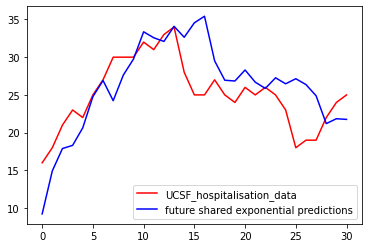

In [642]:
plt.plot(UCSF_data[start_day+k:],'r',label = "UCSF_hospitalisation_data")
plt.plot(shared_exp_future_predictions,'b',label= "future shared exponential predictions")
plt.legend()

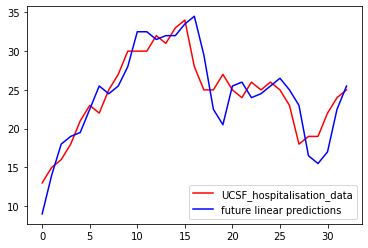

In [639]:
plt.plot(UCSF_data[start_day+k:],'r',label = "UCSF_hospitalisation_data")
plt.plot(lin_future_predictions,'b',label= "future linear predictions")
plt.legend()


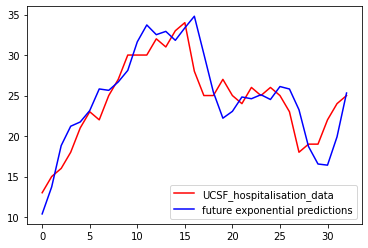

In [640]:
plt.plot(UCSF_data[start_day+k:],'r',label = "UCSF_hospitalisation_data")
plt.plot(exp_future_predictions,'b',label= "future exponential predictions")
plt.legend()


In [648]:
#Imputed Deaths 


TypeError: 'function' object is not subscriptable

In [658]:
df_CA = df_county[df_county['StateName']=='CA']
len(df_CA['deaths'].iloc[0])
#fit_and_predict_ensemble(df_county)

127